In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import pathlib
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception, EfficientNetB2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling, RandomZoom
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam

In [3]:
# Set the path to the split dataset directory
split_dataset_dir = '/content/drive/MyDrive/Dataset_divided'


In [4]:

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])


In [5]:
# Preprocess the data
AUTOTUNE = tf.data.AUTOTUNE



In [6]:

# Define batch size
batch_size = 32

# Function to load and preprocess image and label
def load_and_preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (128, 128))
    img = tf.cast(img, tf.float32) / 255.0  # normalize to [0,1] range
    return img, label

# Create TensorFlow Dataset objects for training data
train_dataset = tf.data.Dataset.list_files(os.path.join(split_dataset_dir, 'train', '*/*'))
train_dataset = train_dataset.shuffle(buffer_size=1000, seed=42)
train_dataset = train_dataset.map(lambda x: (x, tf.one_hot(tf.argmax(tf.strings.split(x, os.sep)[-2] == ['Non_Demented', 'Very_Mild_Demented', 'Moderate_Demented', 'Mild_Demented']), depth=4)))
train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Create TensorFlow Dataset objects for validation data
validation_dataset = tf.data.Dataset.list_files(os.path.join(split_dataset_dir, 'valid', '*/*'))
validation_dataset = validation_dataset.map(lambda x: (x, tf.one_hot(tf.argmax(tf.strings.split(x, os.sep)[-2] == ['Non_Demented', 'Very_Mild_Demented', 'Moderate_Demented', 'Mild_Demented']), depth=4)))
validation_dataset = validation_dataset.map(lambda x, y: load_and_preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)



In [7]:
import tensorflow as tf
from tensorflow.keras.applications import Xception, EfficientNetB2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten


# Define input shape for both models
input_shape = (128, 128, 3)

# Load base models
base_model_Xception = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
base_model_EfficientNetB2 = EfficientNetB2(weights='imagenet', include_top=False, input_shape=input_shape)

# Define inputs
inputs = Input(shape=input_shape)

# Get the outputs of the base models
Xception_output = base_model_Xception(inputs)
EfficientNetB2_output = base_model_EfficientNetB2(inputs)

# Concatenate the outputs
concatenated = Concatenate()([Xception_output, EfficientNetB2_output])

# Freeze some layers of base models
for layer in base_model_Xception.layers[:10]:
    layer.trainable = False

for layer in base_model_EfficientNetB2.layers[:10]:
    layer.trainable = False

x = Conv2D(64, (3, 3), activation='relu', padding='same')(concatenated)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

x = Flatten()(x)

# Add dense layers with L2 regularization
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)

output = Dense(4, activation='softmax')(x)

# Create the ensemble model
ensemble_model = Model(inputs=inputs, outputs=output)

# Compile the model
ensemble_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Adjusted learning rate
    metrics=['accuracy']
)

# Define the learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.8
)

# Specify the path and filename for saving the model
model_save_path = '/content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_EfficientNetB2.h5'

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', restore_best_weights=True),
    ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1),
    TensorBoard(log_dir='./logs', histogram_freq=1)
]


31790344/31790344 [==============================] - 0s 0us/step


In [8]:

ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 xception (Functional)       (None, 4, 4, 2048)           2086148   ['input_3[0][0]']             
                                                          0                                       
                                                                                                  
 efficientnetb2 (Functional  (None, 4, 4, 1408)           7768569   ['input_3[0][0]']             
 )                                                                                                
                                                                                              

In [9]:
# Train the model
history = ensemble_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
230/230 [==============================] - ETA: 0s - loss: 3.2935 - accuracy: 0.4302
Epoch 1: val_loss improved from inf to 2.63097, saving model to /content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_EfficientNetB2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


230/230 [==============================] - 1437s 6s/step - loss: 3.2935 - accuracy: 0.4302 - val_loss: 2.6310 - val_accuracy: 0.5285
Epoch 2/50
230/230 [==============================] - ETA: 0s - loss: 2.5365 - accuracy: 0.5863
Epoch 2: val_loss improved from 2.63097 to 2.14045, saving model to /content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_EfficientNetB2.h5
230/230 [==============================] - 88s 384ms/step - loss: 2.5365 - accuracy: 0.5863 - val_loss: 2.1404 - val_accuracy: 0.7490
Epoch 3/50
230/230 [==============================] - ETA: 0s - loss: 2.0805 - accuracy: 0.7678
Epoch 3: val_loss improved from 2.14045 to 1.87742, saving model to /content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_EfficientNetB2.h5
230/230 [==============================] - 89s 387ms/step - loss: 2.0805 - accuracy: 0.7678 - val_loss: 1.8774 - val_accuracy: 0.8638
Epoch 4/50
230/230 [==============================] - ETA: 0s - loss: 1.7126 - accuracy: 0.8925
Epoch 4: val_

In [10]:

# Save the entire model to a HDF5 file
ensemble_model.save('/content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_EfficientNetB2.h5')


In [11]:
# Load the model from the HDF5 file
loaded_ensemble_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_EfficientNetB2.h5')


In [12]:
# Save the entire model to Google Drive
loaded_ensemble_model.save('/content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_EfficientNetB2.h5')

In [13]:
# Evaluate the model on the validation dataset
model_evaluate = ensemble_model.evaluate(validation_dataset)

# Print validation accuracy and loss
print("Validation Accuracy: {:.2f}%".format(model_evaluate[1] * 100))
print("Validation Loss: {:.2f}%".format(model_evaluate[0] * 100))


50/50 [==============================] - 6s 114ms/step - loss: 0.0321 - accuracy: 0.9911
Validation Accuracy: 99.11%
Validation Loss: 3.21%


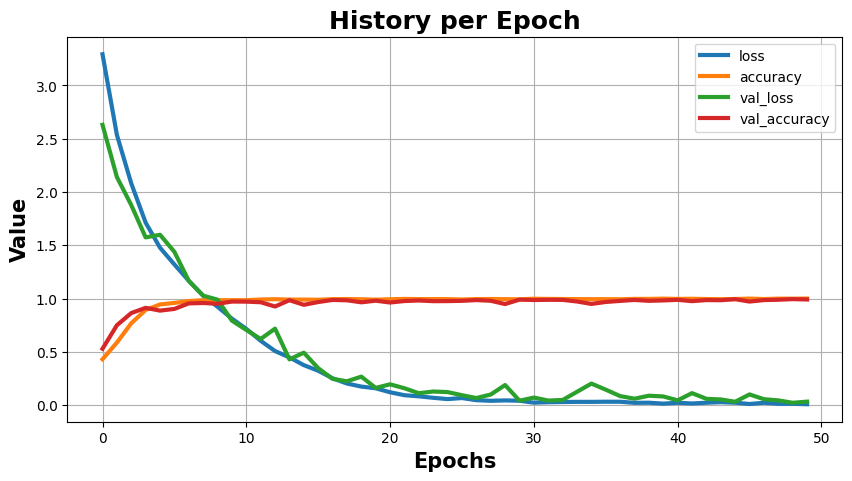

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training history
df = pd.DataFrame(history.history)

# Create the plot
ax = df.plot(figsize=(10, 5), lw=3)
ax.grid(True)
ax.set_title('History per Epoch', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax.set_ylabel('Value', fontsize=15, fontweight='bold')

# Show the plot
plt.show()

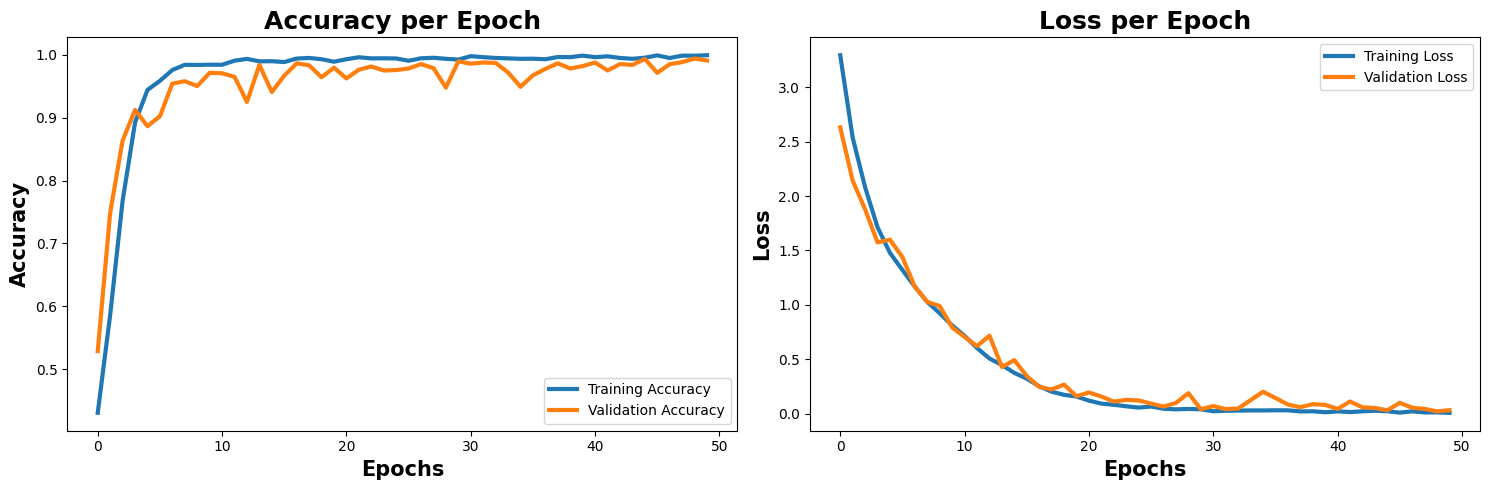

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training history
df = pd.DataFrame(history.history)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(df['accuracy'], label='Training Accuracy', lw=3)
ax1.plot(df['val_accuracy'], label='Validation Accuracy', lw=3)
ax1.set_title('Accuracy per Epoch', fontsize=18, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=15, fontweight='bold')
ax1.legend()

# Plot loss
ax2.plot(df['loss'], label='Training Loss', lw=3)
ax2.plot(df['val_loss'], label='Validation Loss', lw=3)
ax2.set_title('Loss per Epoch', fontsize=18, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=15, fontweight='bold')
ax2.legend()

# Adjust layout for better spacing
fig.tight_layout()

# Show the plot
plt.show()



In [16]:
# Save the entire model to Google Drive
loaded_ensemble_model.save('/content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_EfficientNetB2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


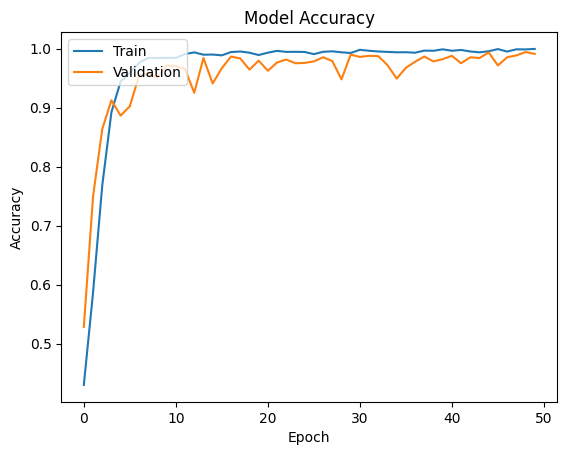

In [17]:

# Visualize Training History
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
# Save the entire model to a HDF5 file
loaded_ensemble_model.save('/content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_DenseNet121.h5')


1/1 [==============================] - 0s 45ms/step
Precision: 0.9904
Recall: 0.9881
F1 Score: 0.9892
Accuracy: 0.9892



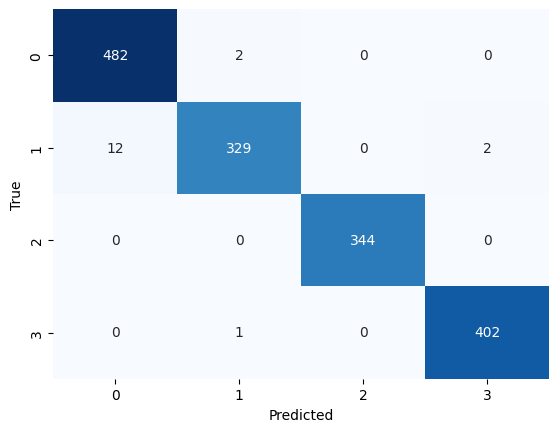

In [20]:
import numpy as np
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Set the path to your test dataset directory
test_dataset_dir = os.path.join(split_dataset_dir, 'test')

# Define a function to preprocess image and label
def preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (128, 128))
    img /= 255.0  # normalize to [0,1] range
    return img

# Load the test data
test_dataset = tf.data.Dataset.list_files(os.path.join(test_dataset_dir, '*/*'))
test_dataset = test_dataset.map(lambda x: (preprocess_image(x), tf.one_hot(tf.argmax(tf.strings.split(x, os.sep)[-2] == ['Non_Demented', 'Very_Mild_Demented', 'Moderate_Demented', 'Mild_Demented']), depth=4)))

# Perform individual predictions and calculate metrics for each model
individual_predictions = []
true_labels = []

for image, label in test_dataset:
    prediction = loaded_ensemble_model.predict(tf.expand_dims(image, axis=0))[0]
    individual_predictions.append(np.argmax(prediction))
    true_labels.append(np.argmax(label))

# Calculate and store metrics for the model
precision = precision_score(true_labels, individual_predictions, average='macro')
recall = recall_score(true_labels, individual_predictions, average='macro')
f1 = f1_score(true_labels, individual_predictions, average='macro')
accuracy = accuracy_score(true_labels, individual_predictions)

ensemble_model_metrics = {
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Accuracy": accuracy
}

# Print metrics
print(f"Precision: {ensemble_model_metrics['Precision']:.4f}")
print(f"Recall: {ensemble_model_metrics['Recall']:.4f}")
print(f"F1 Score: {ensemble_model_metrics['F1 Score']:.4f}")
print(f"Accuracy: {ensemble_model_metrics['Accuracy']:.4f}")
print()

# Display confusion matrix
conf_matrix = confusion_matrix(true_labels, individual_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [21]:
# Save the updated model with the same name
loaded_ensemble_model.save('/content/drive/MyDrive/saved_model/Ensemble_Model_VGG16_and_EfficientNetB2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
